# Permutation Flow-Shop Scheduling Problem

This is a variant of the Flot-shop scheduling problem (FSSP) in which the sequence of jobs is the same in every machine.

$$
 \begin{align}
     \text{min} \quad & C_{\text{max}} \\
     \text{s.t.} \quad & h_{m-1,k} + \sum_{j \in J} p_{j,m-1} x_{j,k} \leq h_{m,k}
         & \forall ~ m \in M \setminus \{1\}; k \in K\\
     & h_{m,k} + \sum_{j \in J} p_{j,m} x_{j,k} \leq h_{m,k+1}
         & \forall ~ m \in M; k \in K \setminus \{|K|\}\\
     & \sum_{j \in J} x_{j,k} = 1
         & \forall ~ k \in K\\
     & \sum_{k \in K} x_{j,k} = 1
         & \forall ~ j \in J\\
     & h_{|M|,|K|} + \sum_{j \in J} p_{j,|M|} x_{j,|K|} \leq C_{\text{max}}\\
     & h_{m,k} \geq 0 & \forall ~ m \in M; k \in K\\
     & x_{j,k} \in \{0, 1\} & \forall ~ j \in J; k \in K\\
 \end{align}
 $$

 You can compare this implementation to MILP solvers at the [end of the notebook](#bonus---milp-model).

In [1]:
import json

from bnbprob.pfssp import CallbackBnB, LazyBnB, PermFlowShop, plot_gantt
from bnbprob.pfssp.cython.bnb import CutoffBnB, TruncateBnB
from bnbprob.pfssp.cython.problem import (
    PermFlowShop2MHalf,
    PermFlowShopCounter,
    PermFlowShopLevelCount,
    PermFlowShopQuit,
)
from bnbprob.pfssp.mip import positional_model
from bnbpy import configure_logfile
# from bnbprob.pfssp.pypure.problem import PermFlowShop

In [2]:
configure_logfile("pfssp-bench.log", mode="w")

In [11]:
with open("./../data/flow-shop/ta016.json", mode="r", encoding="utf8") as f:
    p = json.load(f)

print(f"{len(p)} Jobs; {len(p[0])} Machines")

20 Jobs; 10 Machines


In [12]:
import gc

gc.disable()

In [13]:
problem = PermFlowShop2MHalf.from_p(p, constructive='neh')
bnb = CallbackBnB(
    eval_node='in',
    rtol=0.0001,
    # heur_factor=100,
    save_tree=False,
    queue_mode='dfs',
)

In [14]:
sol = bnb.solve(
    problem, maxiter=1000_000_000, timelimit=3600
)
print(sol)

Status: OPTIMAL | Cost: 1397.0 | LB: 1397.0


In [20]:
type(sol)

bnbpy.cython.solution.Solution

In [26]:
import heapq

for i in range(10):
    print(heapq.heappop(bnb.queue._queue).priority)

(-10, 1575.0, 4962)
(-9, 1571.0, 5058)
(-8, 1534.0, 4333)
(-8, 1557.0, 4482)
(-8, 1557.0, 4625)
(-8, 1564.0, 4567)
(-8, 1576.0, 4763)
(-7, 1525.0, 4340)
(-7, 1529.0, 4241)
(-7, 1529.0, 4781)


In [9]:
sol.sequence

[Job 11,
 Job 11,
 Job 46,
 Job 11,
 Job 11,
 Job 46,
 Job 45,
 Job 11,
 Job 45,
 Job 11]

In [8]:
len(sol.sequence)

10

In [17]:
problem = PermFlowShop2MHalf.from_p(p, constructive='neh')
bnb = CutoffBnB(
    2989,
    eval_node='in',
    rtol=0.0001,
    save_tree=False,
    queue_mode='dfs',
)

In [18]:
sol2 = bnb.solve(
    problem, maxiter=1000_000_000, timelimit=3600 * 8
)
print(sol2)

Status: OPTIMAL | Cost: 2976.0 | LB: 2976.0


In [8]:
sol.compute_starts()
len(sol.sequence)

50

In [9]:
for i, j in enumerate(sol.sequence):
    print(j.r)

[0, 18, 90, 139, 185, 187, 210, 233, 305, 318]
[18, 90, 139, 185, 194, 210, 255, 314, 334, 416]
[80, 107, 173, 194, 203, 261, 343, 367, 416, 502]
[99, 173, 212, 221, 261, 343, 370, 407, 492, 597]
[124, 212, 221, 263, 284, 370, 402, 499, 538, 627]
[200, 217, 263, 272, 342, 402, 499, 519, 584, 684]
[212, 279, 282, 347, 396, 467, 519, 560, 650, 779]
[279, 282, 347, 383, 458, 476, 537, 650, 744, 836]
[280, 291, 383, 446, 475, 518, 635, 744, 787, 841]
[291, 357, 441, 475, 506, 573, 702, 763, 839, 935]
[310, 375, 473, 505, 561, 652, 763, 839, 935, 1025]
[345, 468, 484, 525, 652, 719, 799, 879, 964, 1110]
[440, 480, 508, 613, 672, 799, 879, 960, 1055, 1159]
[452, 524, 590, 642, 763, 824, 926, 1037, 1061, 1165]
[524, 588, 663, 724, 801, 885, 1003, 1058, 1124, 1199]
[566, 663, 738, 801, 835, 966, 1005, 1107, 1199, 1255]
[642, 738, 801, 835, 931, 999, 1082, 1193, 1255, 1328]
[655, 801, 888, 950, 1038, 1091, 1127, 1243, 1303, 1392]
[737, 888, 961, 1038, 1091, 1131, 1196, 1303, 1392, 1455]
[770, 9

In [7]:
bnb.explored

27828976

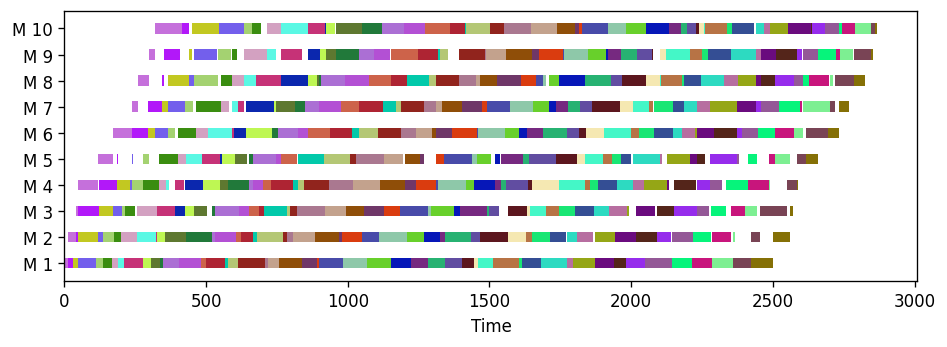

In [8]:
sol.compute_starts()
plot_gantt(sol.sequence, dpi=120, seed=42, figsize=[8, 3])

In [8]:
import pyomo.environ as pyo

model = positional_model(p)

# HiGHS
solver = pyo.SolverFactory('appsi_highs')
solver.options['mip_heuristic_effort'] = 0.1
solver.options['time_limit'] = 600
solver.options['log_file'] = 'Highs.log'
solver.solve(model, tee=True)

Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
RUN!
Coefficient ranges:
  Matrix [1e+00, 1e+02]
  Cost   [1e+00, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 1e+00]
Presolving model
420 rows, 600 cols, 9158 nonzeros  0s
398 rows, 578 cols, 8020 nonzeros  0s

Solving MIP model with:
   398 rows
   578 cols (400 binary, 0 integer, 0 implied int., 178 continuous)
   8020 nonzeros
MIP-Timing:       0.016 - starting analytic centre calculation

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIt

KeyboardInterrupt: 